In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from lens import ray
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

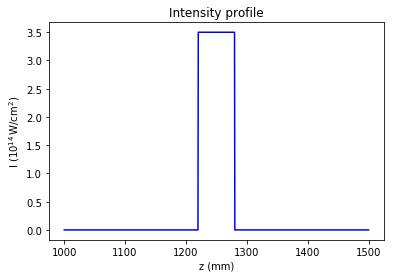

In [2]:
# Test to verify the generalized axicon recreates an axilens
# We'll use the parameters of Sochacki et al. Fig. 3
R = 12.5e3
f0 = 1220e3
dz = 60e3
lam = 0.633
Ic = 3.5
I0 = Ic*dz / (np.pi*R**2) / 10
# Create the z grid
Nz = 1000
Z0 = 1e6
Z = 0.5e6
z = np.linspace(Z0, Z0+Z, Nz)

# Calculate the desired intensity profile
I = np.zeros(Nz)
I[np.array(z > f0) * np.array(z < f0+dz)] = Ic

# Plot initial conditions
plt.plot(z/1e3, I, 'b-')
plt.title('Intensity profile')
plt.xlabel('z (mm)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')

plt.show()

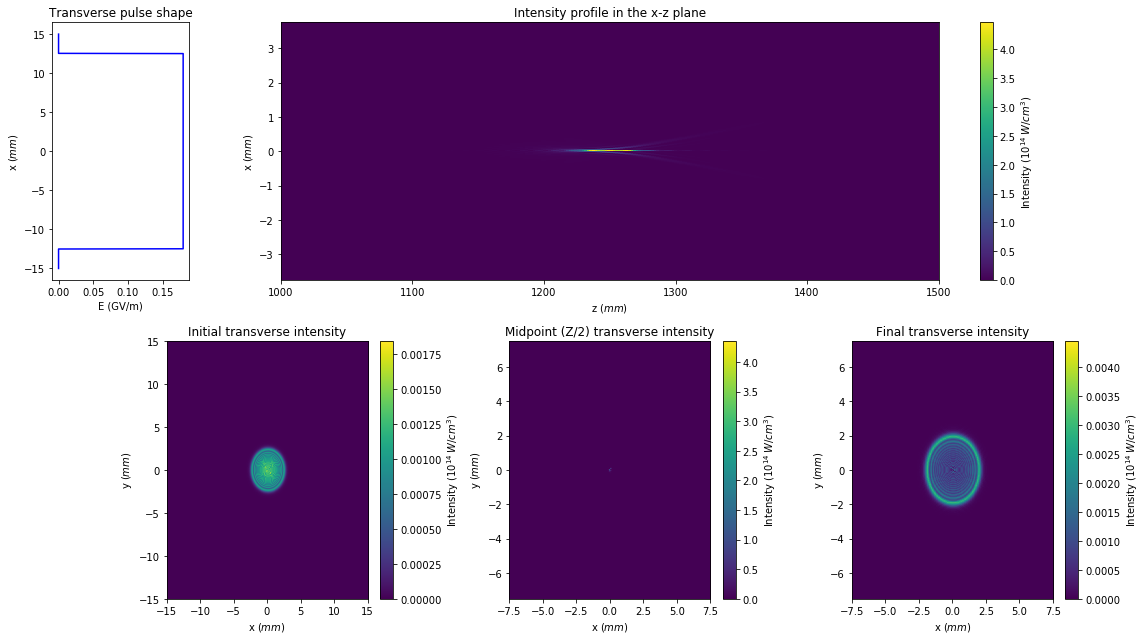

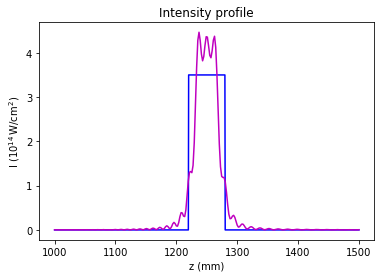

In [6]:
# Simulate the analytic axilens
# Initial electric field
def Efunc(x, y):
    # Input flatop beam
    R = params['R']
    r = np.sqrt(x**2 + y**2)
    E0 = np.zeros(np.shape(r))
    E0[r < R] = 1.0
    # Generalized Axilens
    f0 = params['f0']
    dz = params['dz']
    k = 2*np.pi / params['lam']
    phi = np.zeros(np.shape(r))
    phi[r < R] = -R**2/(2*dz) * np.log(f0+dz*r[r < R]**2/R**2)
    T0 = np.exp(1j*k*phi)
    # Initial electric field
    return E0 * T0

# Setup the parameters
params = {'Nx' : 2**10,
          'Ny' : 2**10,
          'Nz' : 2**8,
          'X' : 30e3,
          'Y' : 30e3,
          'Z' : Z,
          'z0' : Z0,
          'E0' : ionization.field_from_intensity(I0),
          'lam' : lam,
          'n' : 1.0,
          'R' : R,
          'f0' : f0,
          'dz' : dz
          }

path = '/media/robert/Data_Storage/Data/Optics/Axilens/'

directory = 'Axilens_Recreation'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])
# Get the field along the optical axis
Eplot = np.load(params['path']+'electricField.npy')
Iaxis = ionization.intensity_from_field(abs(Eplot[:, int(params['Nx']/2), int(params['Ny']/2)]))
zsim = np.linspace(Z0, Z0+Z, params['Nz'])

plt.plot(z/1e3, I, 'b-', zsim/1e3, Iaxis, 'm-')
plt.title('Intensity profile')
plt.xlabel('z (mm)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')

plt.show()
del Eplot

4.28236723755e-05


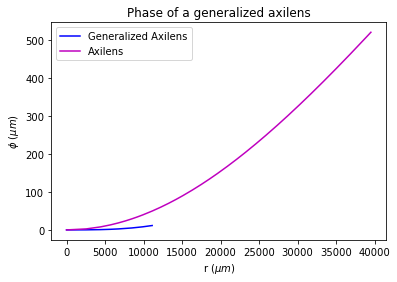

In [15]:
I0, r, phi = ray.uniform_phase(I, z, R)

phia = R**2/dz * np.log(f0+dz*r**2/R**2)/2 - R**2/dz*np.log(f0)/2

print(I0)
plt.plot(r[:-550], abs(phi*200)[:-550],'b-',r, abs(phia), 'm-')
plt.title('Phase of a generalized axilens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.legend(['Generalized Axilens','Axilens'])
plt.show()